# CORNETO multicondition steiner trees on single-cell perturbational data

In this notebook, we illustrate how to apply CORNETO to preprocessed single-cell perturbational data from mice samples. To do so, we leverage the recently released Cytokine atlas data (https://www.nature.com/articles/s41586-023-06816-9).


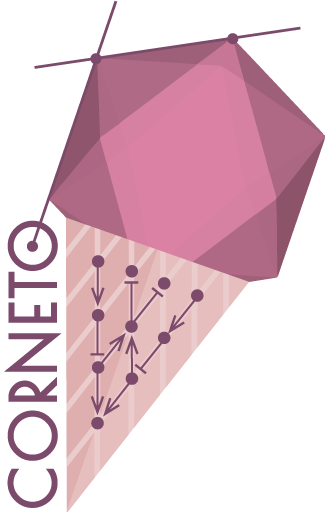

In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# supports owncloud data downloads: pip install pyocclient
import owncloud

# corneto
import corneto as cn
from corneto._graph import EdgeType
from corneto.methods.steiner import exact_steiner_tree

seed = 42

plt.rcParams['text.usetex'] = False
plt.rcParams["pdf.use14corefonts"] = True

sns.set_theme(style="ticks", palette="muted")
sns.set_context("notebook", font_scale=1.5)

cn.info()

First, we load the preprocessed single cell differential data. The preprocessing steps of this dataset involved generating pseudobulk profiles for each cell type, and performing the differential expression analysis between the perturbed and control conditions. The following table contains the results of this differential analysis.

In [2]:
import tempfile

with tempfile.TemporaryDirectory() as temp_dir:
    cache_file = os.path.join(temp_dir, 'cytokine_atlas_deseq.csv.gz')
    if not os.path.exists(cache_file):
        oc = owncloud.Client.from_public_link('https://oc.embl.de/index.php/s/UYitbSUg7uaVVWQ')
        oc.get_file('/cytokine_atlas_deseq.csv.gz', cache_file)
    data = pd.read_csv(cache_file).rename(columns={'drug': 'treatment'})
data

,ID,cell,treatment,logFC,padj,stat
0,0610010K14Rik,Tcellgd,CD40L,-0.378524,0.999805,-0.238942
1,0610010K14Rik,Tcellgd,IL12,0.224078,0.999525,0.148912
2,0610010K14Rik,Tcellgd,IL1ra,-0.360283,0.999389,-0.196232
3,0610012G03Rik,Macrophage,41BBL,0.094481,0.996665,0.112799
4,0610012G03Rik,Macrophage,APRIL,-0.211106,0.996184,-0.258982
...,...,...,...,...,...,...
1141692,mt-Nd5,pDC,VEGF,-0.093461,0.999085,-0.420830
1141693,mt-Nd6,Tcellgd,IGFI,3.581320,0.999940,1.414577
1141694,mt-Nd6,Tcellgd,TL1A,3.092281,0.997553,1.153355
1141695,mt-Nd6,Tcellgd,TSLP,3.159594,0.999378,1.248547


In [6]:
data.cell.unique()

array(['Tcellgd', 'Macrophage', 'NKcell', 'Treg', 'cDC1', 'cDC2', 'pDC',
       'MigDC', 'TcellCD8', 'TcellCD4', 'Bcell'], dtype=object)

Since we are dealing with mouse data, we need to load a mouse-specific prior knowledge network. For this exercise, we import all interactions into omnipath for mouse, including gene-regulation interactions, protein-protein interactions, and signaling interactions.

In [3]:
with tempfile.TemporaryDirectory() as temp_dir:
    cache_file = os.path.join(temp_dir, 'mouse_allints.csv')
    if not os.path.exists(cache_file):
        oc = owncloud.Client.from_public_link('https://oc.embl.de/index.php/s/UYitbSUg7uaVVWQ')
        oc.get_file('/mouse_allints.csv', cache_file)
    ppi_df = pd.read_csv(cache_file)
    ppi_df = ppi_df[['source_genesymbol', 'target_genesymbol']].drop_duplicates()
    ppi_net = nx.from_pandas_edgelist(ppi_df, source='source_genesymbol', target='target_genesymbol')
ppi_df

C:\Users\pablo\AppData\Local\Temp\ipykernel_2660\2722679280.py:6: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  ppi_df = pd.read_csv(cache_file)


,source_genesymbol,target_genesymbol
0,Calm1,Trpc1
1,Calm2,Trpc1
2,Calm3,Trpc1
3,Cav1,Trpc1
4,Drd2,Trpc1
...,...,...
170667,Tcf3,Polb
170668,Rxrg,Atp2a2
170669,Nfe2l2,Akr1c6
170670,Creb3l3,Pou1f1


Next, we generate an overview of the data after discretizing the genes for each contrast as up or down regulated

In [4]:
# add label up or down if logFC > 1 and padj < 0.01 or non otherwise
data['label'] = 'Not significant'
data.loc[(data['logFC'] > 0) & (data['padj'] <= 0.05), 'label'] = 'Up'
data.loc[(data['logFC'] < 0) & (data['padj'] <= 0.05), 'label'] = 'Down'

findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: 

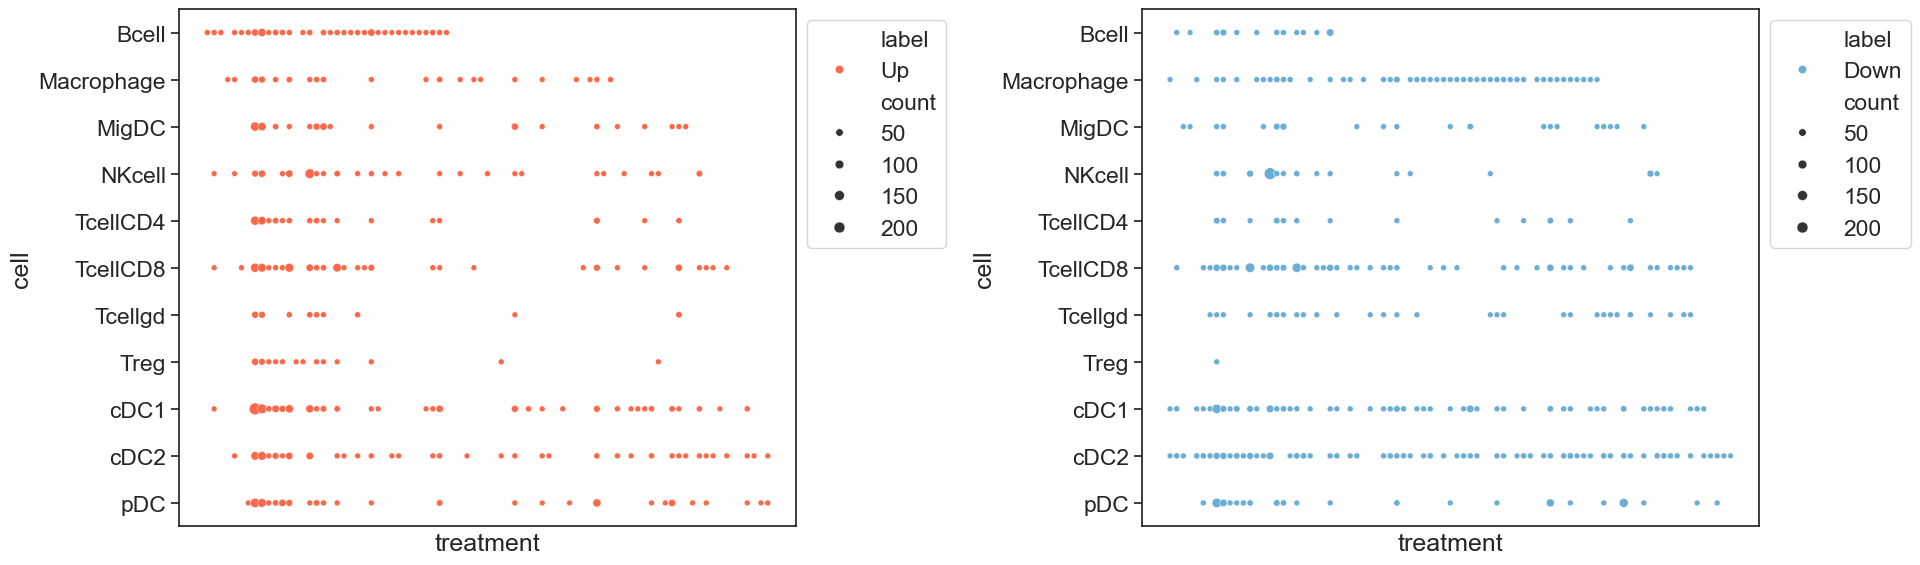

In [5]:
cell_summary = data.groupby(['cell',  'treatment', 'label']).size().reset_index(name='count')
cell_summary = cell_summary[cell_summary['label'] != 'Not significant']
cell_summary['cell'] = pd.Categorical(cell_summary['cell'], categories=cell_summary['cell'].unique(), ordered=True)
cell_summary['treatment'] = pd.Categorical(cell_summary['treatment'], categories=cell_summary['treatment'].unique(), ordered=True)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(23, 6))

sns.scatterplot(data=cell_summary[cell_summary['label'] == 'Up'], x='treatment', y='cell', size='count', ax=axs[0], hue='label', palette='Reds', legend=True)
sns.scatterplot(data=cell_summary[cell_summary['label'] == 'Down'], x='treatment', y='cell', size='count', ax=axs[1], hue='label', palette='Blues', legend=True)

for ax in axs:
    ax.set_xticks([])
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout to make room for the legends
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.savefig('cytokine_treatment_effects.pdf', format='pdf', transparent=True)

As an example of how to apply CORNETO to single-cell data, here we construct cell type-specific subnetworks using multicondition Steiner trees. Briefly, for each cell type, we retrieve the 10 treatments with the highest number of differentially expressed genes. We then construct a multicondition Steiner tree for each cell type using the deregulated genes from each top treatment as terminals.

In [7]:
# define a function to perform corneto_steiner trees given a graph, a set of terminals and a lambda parameter
def corneto_multicond_st(g, terminals, l, edge_weight=0.01, solver_opts=None):
    if solver_opts is None:
        solver_opts = dict(solver="GUROBI", verbosity=1, IntegralityFocus=1, TimeLimit=300, Seed=seed)

    # create corneto graph
    nx_edges = [(u, v) for u, v in g.edges]
    corneto_g = cn.Graph()
    corneto_g.add_edges(nx_edges, type=EdgeType.UNDIRECTED, weight=edge_weight)

    # prepare and solve the problem
    P = cn.methods.steiner.create_exact_multi_steiner_tree(corneto_g, terminals, strict_acyclic=True, lam=l)
    P.solve(**solver_opts)

    # retrieve selected edges as a networkx graph
    sel_edges = set()
    for i in range(len( terminals )):
        flow_edges = np.flatnonzero(np.abs(P.expr['flow' + str(i)].value[:corneto_g.shape[1]]) >= 1e-6)
        sel_edges.update(set(flow_edges))

    nx_edges = [(list(i)[0], list(j)[0]) for i, j in corneto_g.edge_subgraph(sel_edges).E]
    nx_output = nx.Graph()
    nx_output.add_edges_from(nx_edges)

    return nx_output

In [9]:
diff_data = data[data['label'] != 'Not significant'].copy()
diff_data

,ID,cell,treatment,logFC,padj,stat,label
1503,1600014C10Rik,TcellCD8,IFNa1,2.106548,0.013840,3.076222,Up
1504,1600014C10Rik,TcellCD8,IFNb,2.005566,0.017802,3.037776,Up
6741,4930523C07Rik,TcellCD8,IL15,-1.976528,0.000002,-5.511009,Down
6750,4930523C07Rik,TcellCD8,IL1a,-1.426742,0.021263,-3.387311,Down
6753,4930523C07Rik,TcellCD8,IL2,-1.775254,0.000358,-4.221316,Down
...,...,...,...,...,...,...,...
1140690,mt-Nd4l,pDC,IFNa1,-0.885867,0.027607,-2.852199,Down
1140719,mt-Nd4l,pDC,IL3,-1.015666,0.026990,-3.057108,Down
1141210,mt-Nd5,TcellCD8,IL15,-0.712946,0.013493,-3.066707,Down
1141222,mt-Nd5,TcellCD8,IL2,-0.793652,0.018062,-2.930505,Down


In [25]:
cell_type_networks = []

for int_cell in data['cell'].unique():

    print('Generating network for cell type', int_cell)

    # get the top 10 treatments with highest number of significant genes
    cell_df = diff_data[diff_data['cell'] == int_cell]
    treatments = cell_df.groupby('treatment').size().sort_values(ascending=False).head(10)
    print(treatments)
    int_treatments = treatments.index
    cell_df = cell_df[cell_df['treatment'].isin(int_treatments)]

    # subset graph to IDs in the cell_df
    ppi_subnet = ppi_net.subgraph(cell_df['ID'].unique())
    largest_cc = max(nx.connected_components(ppi_subnet), key=len)
    ppi_subnet = ppi_subnet.subgraph(largest_cc).copy()

    # subset cell_df to the nodes in the ppi_subnet
    cell_df = cell_df[cell_df['ID'].isin(ppi_subnet.nodes)]

    # create a list of lists, with the genes for every treatment 
    corneto_input = []
    for treatment, df in cell_df.groupby('treatment'):
        corneto_input.append(df['ID'].tolist())
    corneto_input = [i for i in corneto_input if len(i) > 1]

    # run corneto
    print(corneto_input)
    result = corneto_multicond_st(ppi_subnet, corneto_input, 0.1)
    cell_type_networks.append(result)

Generating network for cell type Tcellgd
treatment
IFNa1     38
IFNb      33
IL7       25
IL18      20
IL1a      18
IL15      13
IL23       8
IL1b       7
Noggin     2
TSLP       2
dtype: int64
[['Ccnd2', 'Cxcl10', 'Fos', 'H2-T23', 'Ifi203', 'Irf7', 'Isg15', 'Mndal', 'Psme1', 'Selenow', 'Tapbp'], ['Ccnd2', 'Cxcl10', 'H2-T23', 'Ifi203', 'Irf7', 'Isg15', 'Mndal', 'Psme1'], ['Calr', 'Ccl5', 'Cxcl10', 'Eif4a1', 'Fos', 'Hsp90ab1', 'Hsp90b1', 'Hspa5'], ['Calr', 'Cd82', 'Cxcl10', 'Eif5a', 'Fos', 'Gbp4', 'Hsp90ab1', 'Junb', 'Jund', 'Klf2', 'Nkg7', 'Npm1', 'Psme2'], ['Calr', 'Ccl5', 'Eif5a', 'Fos', 'Fosb', 'Hsp90ab1', 'Jun', 'Junb', 'Ncl', 'Npm1', 'Odc1', 'S100a10'], ['Eif5a', 'Hsp90ab1', 'Ncl', 'Npm1', 'Odc1'], ['Calr', 'Ccl5', 'Hsp90ab1', 'Hsp90b1', 'Serpinb1a'], ['Actb', 'Calr', 'Eif4a1', 'Eif5a', 'Hsp90aa1', 'Hsp90ab1', 'Hsp90b1', 'Hspa5', 'Jun', 'Klf2', 'Ncl', 'Nme1', 'Npm1', 'Pdia6'], ['Egr1', 'Fos']]
(68,)
(68,)
(68,)
(68,)
(68,)
(68,)
(68,)
(68,)
(68,)
I (9, 68)
OR (68,)
               

C:\Users\pablo\miniconda3\envs\corneto-dev0\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Generating network for cell type Treg
treatment
IFNa1    44
IFNb     26
IL1a      2
GCSF      1
IFNe      1
IFNg      1
IFNk      1
IL17B     1
IL17D     1
IL17E     1
dtype: int64
[['Cxcl10', 'Irf7', 'Isg15'], ['Cxcl10', 'Irf7', 'Isg15']]
(2,)
(2,)
I (2, 2)
OR (2,)
                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Aug 09 10:49:19 AM: Your problem has 48 variables, 124 constraints, and 0 parameters.
(CVXPY) Aug 09 10:49:19 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 09 10:49:19 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 09 10:49:19 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Aug 09 10:49:19 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------

C:\Users\pablo\miniconda3\envs\corneto-dev0\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Generating network for cell type cDC2
treatment
IFNb     135
IFNa1    123
IL18     102
IL15      75
IFNg      48
IL2       23
OSM       19
IL10      16
IL3       16
IL36a     16
dtype: int64
[['Actb', 'Ass1', 'Avpi1', 'Bbx', 'Btg2', 'Camk1d', 'Ccl5', 'Ccnd1', 'Ccnd2', 'Ccr2', 'Cct3', 'Cd83', 'Cdkn1a', 'Cmpk2', 'Cx3cr1', 'Cxcl9', 'Cycs', 'Dtx3l', 'Dusp1', 'Epsti1', 'Flnb', 'Fos', 'Fosb', 'Gbp2', 'Gbp4', 'Hspa5', 'Ier2', 'Ifi203', 'Ifi35', 'Ifih1', 'Ifitm3', 'Ifngr1', 'Jun', 'Klf2', 'Klf4', 'Ly6e', 'Mmp12', 'Mndal', 'Nmi', 'Nr4a2', 'Nr4a3', 'Oas3', 'Oasl1', 'Parp14', 'Pfkp', 'Pml', 'Psmb10', 'Psme2', 'Samhd1', 'Selenow', 'Sirpa', 'Sp110', 'Stat2', 'Tagln2', 'Tap1', 'Tapbp', 'Trafd1', 'Tsc22d3', 'Tspo', 'Ube2l6'], ['Bbx', 'Btg2', 'Calm1', 'Ccl5', 'Ccnd1', 'Ccnd2', 'Ccr7', 'Cct3', 'Cd40', 'Cdkn1a', 'Cmpk2', 'Colgalt1', 'Csf1r', 'Cx3cr1', 'Cxcl9', 'Daglb', 'Dhx58', 'Dusp1', 'Epsti1', 'Flnb', 'Fos', 'Fosb', 'Fyn', 'Gbp2', 'Gbp4', 'Gbp5', 'H2-T23', 'Hsp90aa1', 'Ier2', 'Ifi203', 'Ifi35', 'Ifih

C:\Users\pablo\miniconda3\envs\corneto-dev0\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


treatment
IFNa1    258
IL3      154
IL36a    149
IFNb     147
IFNk      53
IL15      42
TNFa      32
IL1a      31
IFNg      18
IL1b      16
dtype: int64
[['Actb', 'Actg1', 'Anxa5', 'B2m', 'Calm1', 'Calr', 'Ccnd1', 'Ccr5', 'Cd69', 'Cd82', 'Cd8a', 'Cfl1', 'Ciita', 'Clec12a', 'Ctsl', 'Cyba', 'Cybb', 'Ddx5', 'Dnajc7', 'Eef1a1', 'Eef1g', 'Eef2', 'Fcrla', 'Fth1', 'Gnaq', 'H2-D1', 'H2-DMa', 'H2-K1', 'H2-Q7', 'H2-T23', 'Herc6', 'Hnrnpa1', 'Hsp90aa1', 'Hsp90ab1', 'Hspa5', 'Ifi203', 'Ifi35', 'Ifitm3', 'Il16', 'Irf7', 'Isg15', 'Isg20', 'Jun', 'Kdr', 'Klk1', 'Klrd1', 'Lgals1', 'Ly86', 'Mapkapk2', 'Mef2c', 'Mndal', 'Naca', 'Nek6', 'Nop53', 'Parp14', 'Pfn1', 'Plaur', 'Pml', 'Psmb10', 'Psmb9', 'Ptpn18', 'Ptpn6', 'Rack1', 'Rap1a', 'Rnf213', 'Rpl10', 'Rpl10a', 'Rpl12', 'Rpl23a', 'Rpl24', 'Rpl3', 'Rpl32', 'Rpl7', 'Rps11', 'Rps12', 'Rps19', 'Rps29', 'Samhd1', 'Sdc3', 'Sdc4', 'Sp110', 'Spib', 'Stat2', 'Sub1', 'Tagln2', 'Tapbp', 'Tor1aip1', 'Tspo', 'Ube2l6', 'Usp18', 'Zeb2'], ['Actb', 'Actg1', 'Calm1', 'Cc

C:\Users\pablo\miniconda3\envs\corneto-dev0\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
I (9, 100)
OR (100,)
                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Aug 09 11:04:35 AM: Your problem has 4947 variables, 13255 constraints, and 0 parameters.
(CVXPY) Aug 09 11:04:35 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 09 11:04:35 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 09 11:04:35 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Aug 09 11:04:35 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
--------------------------------------------------------------

C:\Users\pablo\miniconda3\envs\corneto-dev0\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


(67,)
(67,)
(67,)
(67,)
(67,)
(67,)
(67,)
(67,)
(67,)
(67,)
I (10, 67)
OR (67,)
                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Aug 09 11:10:38 AM: Your problem has 3701 variables, 9870 constraints, and 0 parameters.
(CVXPY) Aug 09 11:10:38 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 09 11:10:38 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 09 11:10:38 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Aug 09 11:10:38 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------

Finally, we can visualize the cell-type specific subnetworks, which can then be used for further interpretation and analysis. Notably, many of these networks highlight the proteins JUN and STAT3 in very central positions. Both proteins are well-studied for their roles in the immune response across various cell types, explaining their prominence in linking responses to different perturbations. Additionally, nodes unique to specific cell-type subnetworks can be investigated to understand cell-type specific effects that influence the response to various perturbations.

In [30]:
for g in cell_type_networks:
    print(len(g.nodes))

37
7
237
3
263
123
144
75
192
53
66


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, san

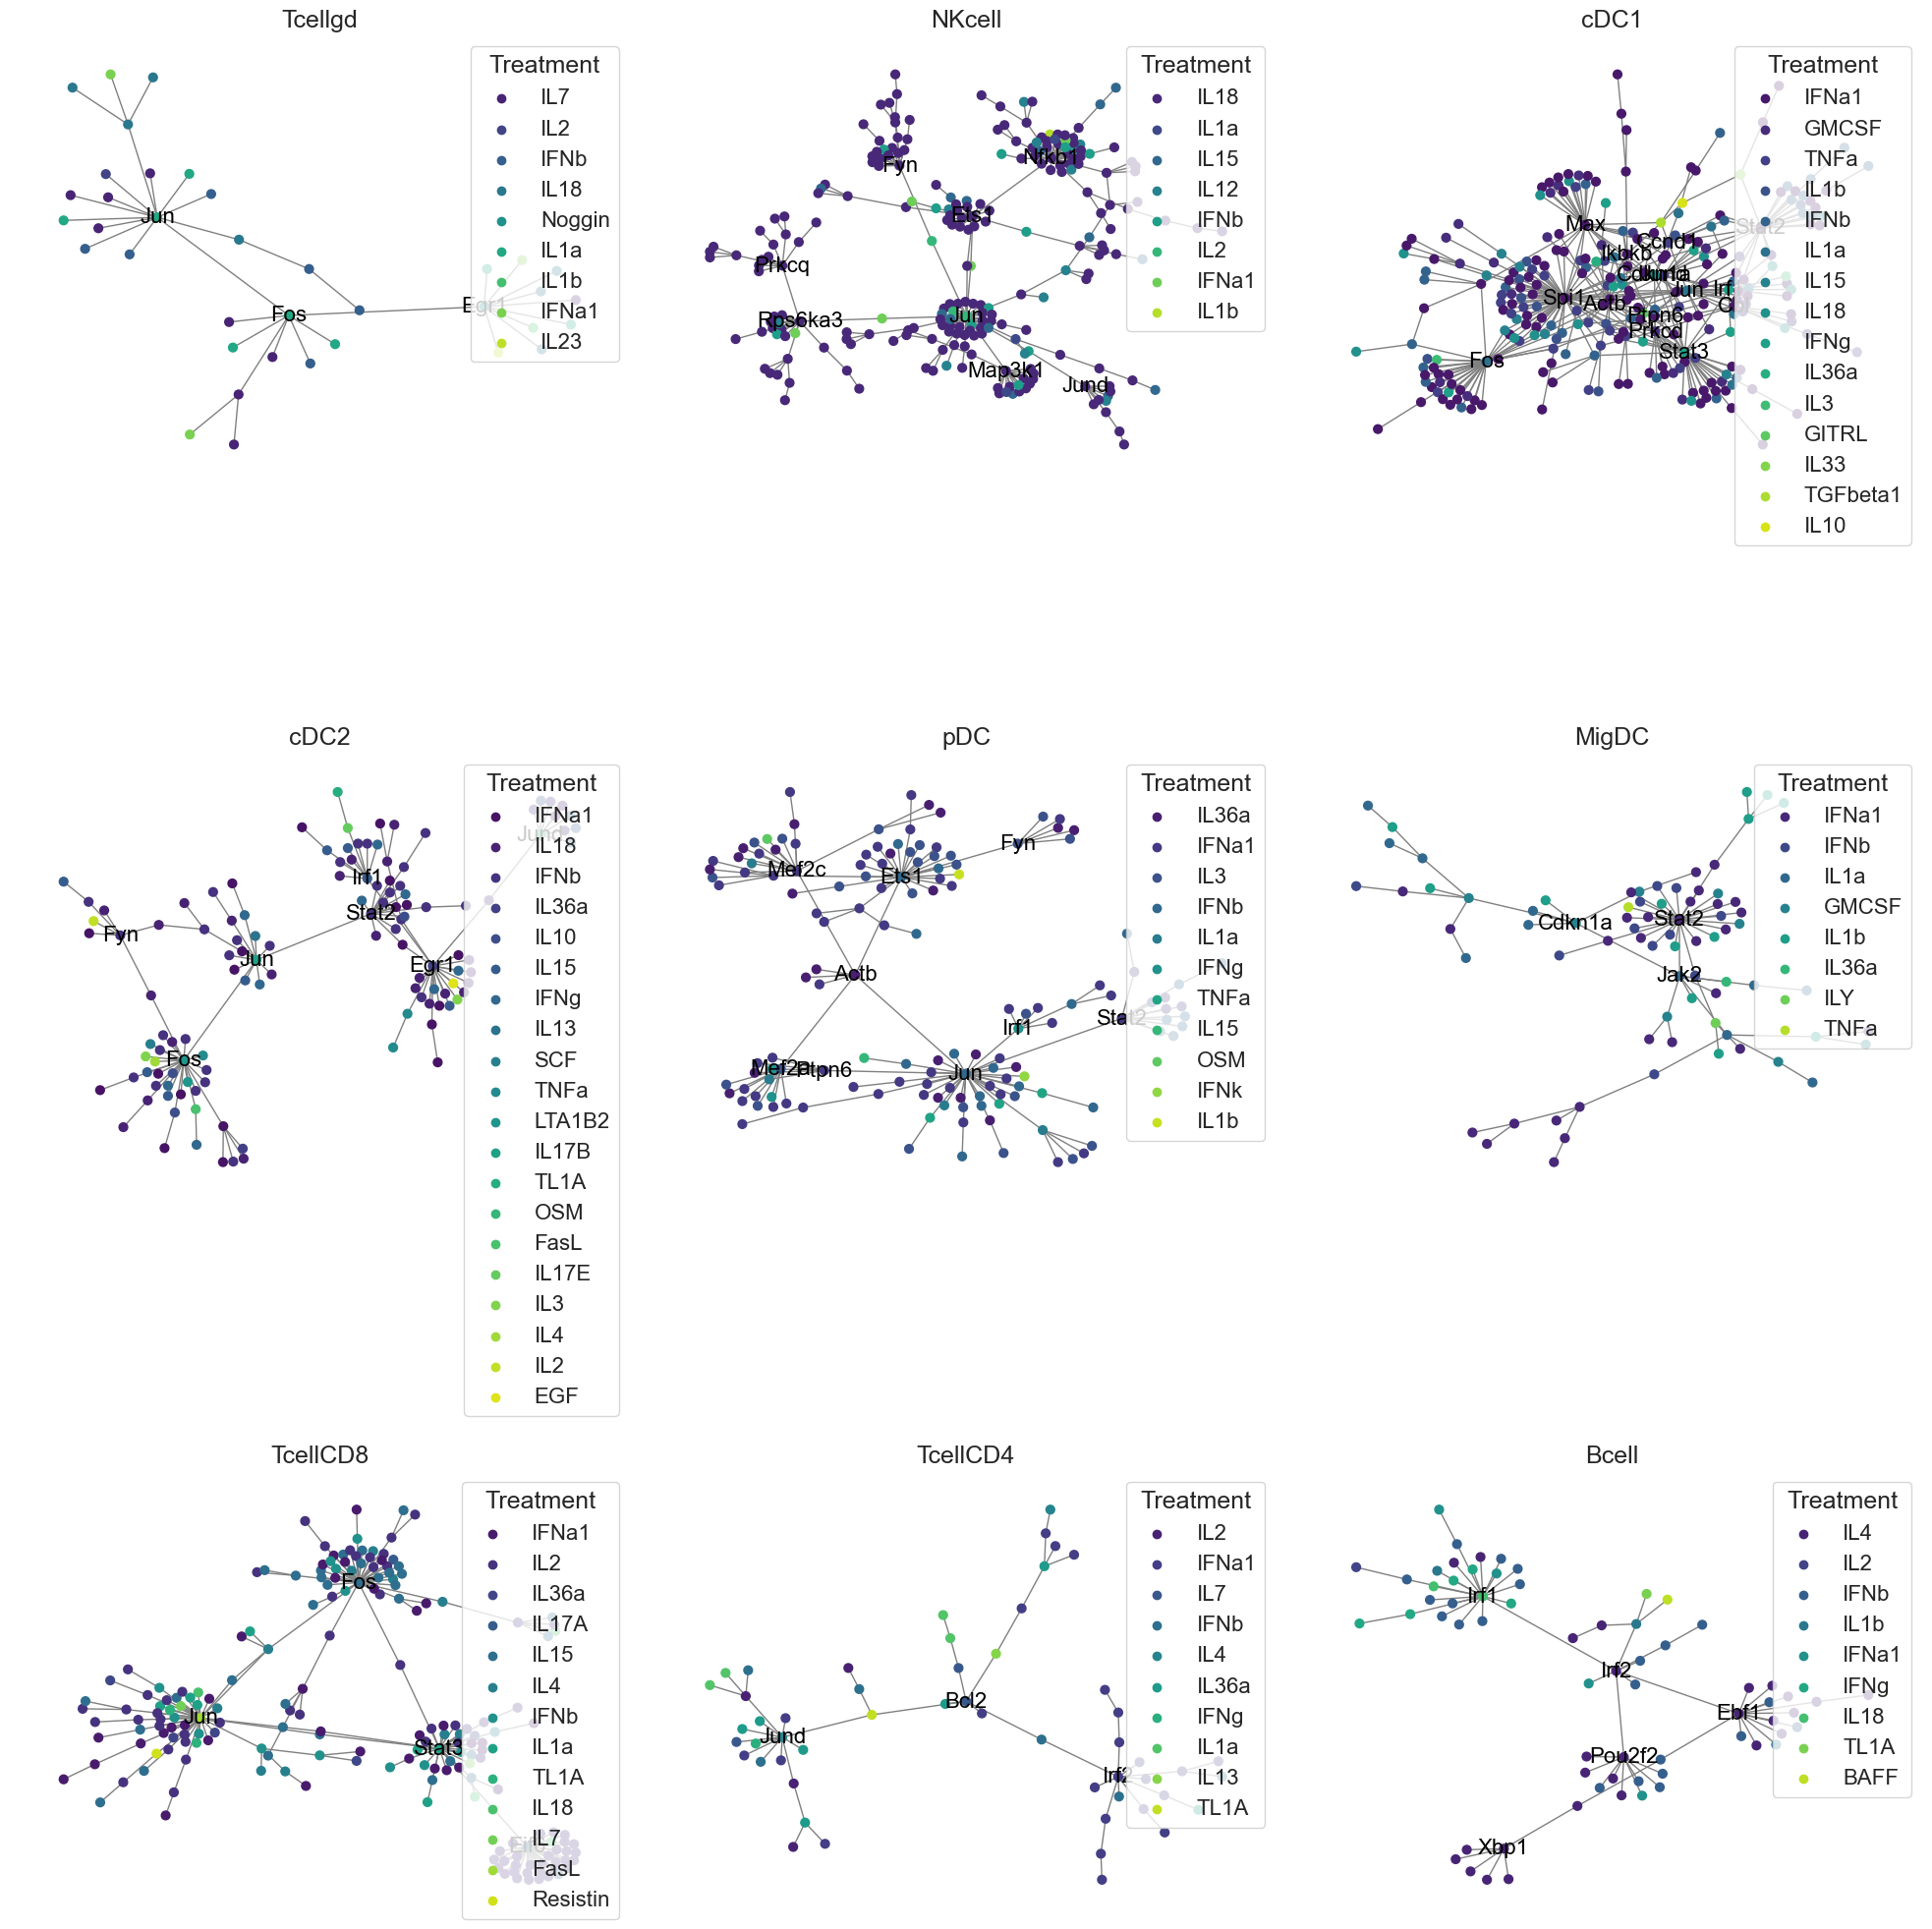

In [33]:
# define a panel with as many panels as cell types
fig, axs = plt.subplots(3,3, figsize=(20, 20))
axs = axs.flatten()
networks_toplot = [g for g in cell_type_networks if len(g.nodes) > 10]
cell_types_toplot = [c for c, g in zip(data['cell'].unique(), cell_type_networks) if len(g.nodes) > 10]

for i, g, cell in zip(range(len(networks_toplot)), networks_toplot, cell_types_toplot):
    cell_df = diff_data[diff_data['cell'] == cell].copy()
    cell_df = cell_df[cell_df['ID'].isin(g.nodes)]
    # for each node in the graph, get the treatment with higest absolute logFC
    top_fc_nodes = cell_df.groupby('ID')[['ID','treatment','logFC']].apply(lambda x: x.loc[x['logFC'].abs().idxmax()])
    top_fc_nodes = top_fc_nodes[['ID', 'treatment']].reset_index(drop=True)
    # map to the treatments to the viridis palette
    palette = sns.color_palette('viridis', len(top_fc_nodes['treatment'].unique()))
    top_fc_nodes['color'] = top_fc_nodes['treatment'].map({t: c for t, c in zip(top_fc_nodes['treatment'].unique(), palette)})
    node_to_color = {n: c for n, c in zip(top_fc_nodes['ID'], top_fc_nodes['color'])}
    # for each node in the network, assign a color if in node to color otherwise gray
    node_colors = ['black' if n not in node_to_color else node_to_color[n] for n in g.nodes]
    node_labels = {node: node if len(list(g.neighbors(node))) > 5 else '' for node in g.nodes}
    nx.draw(g, labels = node_labels, node_color=node_colors, edge_color='gray', node_size=40, font_size=16, font_color='black', ax=axs[i])
    # add treatment legend
    for j, t in enumerate(top_fc_nodes['treatment'].unique()):
        axs[i].scatter([], [], color=palette[j], label=t)
    # add legend with small font
    axs[i].legend(loc='upper right', title='Treatment', fontsize=16)
    axs[i].set_title(cell)
axs[-1].axis('off')
plt.tight_layout()
plt.savefig('cytokine_usteiner.pdf', format='pdf')